Mounting Google Drive

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/pytorch_tiramisu')

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


Dependencies

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

from models import tiramisu
from datasets import camvid
from datasets import joint_transforms
import utils.imgs as img_utils
import utils.training as train_utils

CamVid

In [ ]:
# the CamVid datasaet can be found at https://github.com/alexgkendall/SegNet-Tutorial

CAMVID_PATH = ('/content/drive/MyDrive/SegNet-Tutorial/CamVid')
RESULTS_PATH = Path('/content/drive/MyDrive/pytorch_tiramisu/results103')
WEIGHTS_PATH = Path('/content/drive/MyDrive/pytorch_tiramisu/weights103')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)
batch_size = 1

In [ ]:
normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std)

## TRAIN ##
# no fine tuning
train_joint_transformer = transforms.Compose([
    joint_transforms.JointRandomCrop(224), # commented for fine-tuning
    joint_transforms.JointRandomHorizontalFlip()
    ])
train_dset = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))
train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=True)

# fine tuning
train_joint_transformer_ft = transforms.Compose([
    #joint_transforms.JointRandomCrop(224), # commented for fine-tuning
    joint_transforms.JointRandomHorizontalFlip()
    ])
train_dset_ft = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer_ft,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))
train_loader_ft = torch.utils.data.DataLoader(
    train_dset_ft, batch_size=batch_size, shuffle=True)

## VALIDATION ##
val_dset = camvid.CamVid(
    CAMVID_PATH, 'val', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

## TEST ##
test_dset = camvid.CamVid(
    CAMVID_PATH, 'test', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

Train: 367
Val: 101
Test: 233
Classes: 12
Inputs:  torch.Size([1, 3, 224, 224])
Targets:  torch.Size([1, 224, 224])


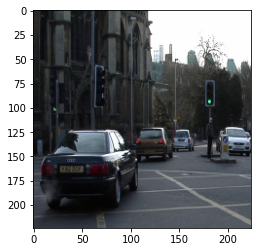

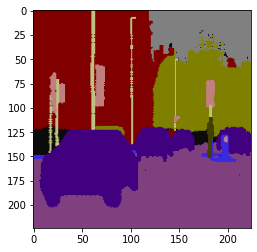

In [ ]:
print("Train: %d" %len(train_loader.dataset.imgs))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))
print("Classes: %d" % len(train_loader.dataset.classes))

inputs, targets, _ = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

img_utils.view_image(inputs[0])
img_utils.view_annotated(targets[0])

Train

In [ ]:
# Hyperparameters

LR = 1e-3
LR_FT = 1e-4
LR_DECAY = 0.995 
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 874
N_FT_EPOCHS = 50
torch.cuda.manual_seed(42)

In [ ]:
# Model, optimizer, and loss function

model = tiramisu.FCDenseNet103(n_classes=12).cuda()
model.apply(train_utils.weights_init)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
optimizer_ft = torch.optim.RMSprop(model.parameters(), lr=LR_FT, weight_decay=1e-4)
criterion = nn.NLLLoss(weight=camvid.class_weight.cuda()).cuda()

In [ ]:
# Uncomment this cell if you want to load weights 

train_utils.load_weights(model, '/content/drive/MyDrive/pytorch_tiramisu/weights103latest.th')

loading weights '/content/drive/MyDrive/pytorch_tiramisu/weights103latest.th'
loaded weights (lastEpoch 917, loss 0.1993816595266361, error 0.07671967893838882)


917

In [ ]:
# Uncomment this cell if you want to train 
# Also uncomment line 98 in tiramisu.py (out = self.softmax(out)) 

# train_losses, val_losses = [], []
# train_acc, val_acc = [], []

# for epoch in range(1, N_EPOCHS+N_FT_EPOCHS+1):
#     since = time.time()

#     ### Train ###
#     if epoch <= N_EPOCHS: ## not fine tuning
#         trn_loss, trn_err = train_utils.train(model, train_loader, optimizer, criterion, epoch)
#     else:
#         trn_loss, trn_err = train_utils.train(model, train_loader_ft, optimizer_ft, criterion, epoch)
#     print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
#         epoch, trn_loss, 1-trn_err))    
#     time_elapsed = time.time() - since  
#     print('Train Time {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))

#     ### Test ###
#     val_loss, val_err = train_utils.test(model, val_loader, criterion, epoch)    
#     print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
#     time_elapsed = time.time() - since  
#     print('Total Time {:.0f}m {:.0f}s\n'.format(
#         time_elapsed // 60, time_elapsed % 60))

#     ### Plot ###
#     train_losses.append(trn_loss)
#     val_losses.append(val_loss)
#     plt.figure(figsize=(10,5))
#     plt.title("Training and Validation Loss")
#     plt.plot(val_losses,label="val")
#     plt.plot(train_losses,label="train")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.legend()
#     plt.show()
    
#     ### Checkpoint ###    
#     print('Saving model checkpoints', epoch)
#     print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
#     train_utils.save_weights(model, epoch, val_loss, val_err, WEIGHTS_PATH='/content/drive/MyDrive/pytorch_tiramisu/weights103')

#     ### Adjust Lr ###
#     train_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
#                                      epoch, DECAY_EVERY_N_EPOCHS)

Get Results

In [ ]:
# where images used to make the videos reside

ENT_VIDEO_PATH = Path('/content/drive/MyDrive/pytorch_tiramisu/ENT')
ENT_VIDEO_PATH.mkdir(exist_ok=True)
AU_VIDEO_PATH = Path('/content/drive/MyDrive/pytorch_tiramisu/AU')
AU_VIDEO_PATH.mkdir(exist_ok=True)
EU_VIDEO_PATH = Path('/content/drive/MyDrive/pytorch_tiramisu/EU')
EU_VIDEO_PATH.mkdir(exist_ok=True)
IMG_VIDEO_PATH = Path('/content/drive/MyDrive/pytorch_tiramisu/IMG')
IMG_VIDEO_PATH.mkdir(exist_ok=True)
PRED_VIDEO_PATH = Path('/content/drive/MyDrive/pytorch_tiramisu/PRED')
PRED_VIDEO_PATH.mkdir(exist_ok=True)

In [ ]:
def get_pixels(output):
    '''
    Reshapes the (12, 360, 480) NN output into (172800, 12) such that
    output[:, 0, 0] = reshaped_output[0]
    output[:, 0, 1] = reshaped_output[1]
    ...
    output[:, 359, 478] = reshaped_output[172798]
    output[:, 359, 479] = reshaped_output[172799]
    '''
    pixels = np.reshape(np.ravel(output), 
                        (output.shape[1] * output.shape[2], output.shape[0]), 
                        order="F")
    return pixels

def softmax(pred):
    '''
    Softmax function. Expects input of shape (172800, 12). Output has shape (172800, 12)
    '''
    e_x = np.exp(pred - np.amax(pred, axis=1, keepdims=True))
    prob = e_x / np.sum(e_x, axis=1, keepdims=True)
    return prob

def calc_entropy(pred):
    '''
    Calculates entropy. 
    '''
    return -np.sum(pred * np.log(pred), axis=1)

def get_results(model, loader, num_samples):
    '''
    returns the following from a dataloader: 
    original images, NN outputs, labelled grount truth images, and image paths
    '''
    # keep dropout layers open by setting model to train mode
    # this allows for monte carlo sampling
    model.train() 
    
    # original (i.e. unlabelled images) from the loader
    originals = [] 
    # NN outputs, grouped into batches of size num_samples
    results = [] 
    # labelled ground truth images
    targets = [] 
    # paths to the images in the loader
    paths = [] 
    
    with torch.no_grad():
        for data, target, path in loader:
            # data.shape = (1, 3, 360, 480)
            originals.append(data[0])
            data = data.to(torch.device("cuda"))

            # target.shape = (1, 360, 480)
            # target = np.reshape(target, (172800))
            target = np.reshape(target, (target.shape[1] * target.shape[2]))
            target = target.cpu().data.numpy()
            targets.append(target)
            
            #  mc sampling    
            mc_results = []
            for _ in range(num_samples):
            # for _ in range(4):
                # output.shape = (1, 12, 360, 480)
                output = model(data).cpu().data.numpy()
                # output = np.reshape(output, (12, 360, 480))
                output = np.squeeze(output)
                mc_results.append(output)
            results.append(mc_results)

            # paths, used for writing images to a directory
            paths.append(path)

    return originals, results, targets, paths

def get_preds(results, num_imgs):
    '''
    gets one batch of predictions from the results list returned by get_results()
    '''
    all_preds = []
    # first num_imgs images in test dataset
    for i in range(num_imgs):
        # img_res contains outputs of num_saamples passes thru the NN
        img_res = results[i]
        preds = []
        # mc dropout
        for j in range(len(img_res)):
            pixels = get_pixels(img_res[j])
            preds.append(softmax(pixels))
        all_preds.append(preds)
    return all_preds

def calc_entropies(probs):
    '''
    Calculates entropy of an image
    '''
    entropies = []
    for prob in probs:
        avg_probs = np.mean(prob, axis=0)
        entropies.append(calc_entropy(avg_probs))
    return entropies # this is a list of entropies for the first X imgs in the test dataset

def calc_aleatoric(probs):
    '''
    Calculates aleatoric uncertainty of an image
    '''
    aleatoric = []
    for prob in probs:
        ent = [calc_entropy(p) for p in prob]
        aleatoric.append(np.mean(ent, axis=0))
    return aleatoric

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


IMAGE NUMBER:  0
('/content/drive/MyDrive/SegNet-Tutorial/CamVid/val/0016E5_08111.png',)
ACCURACY:  0.9169039351851852
ENTROPY AUROC:  0.9271794186994091
ENTROPY AUPR:  0.9929037882126949
ENTROPY VISUALIZATION


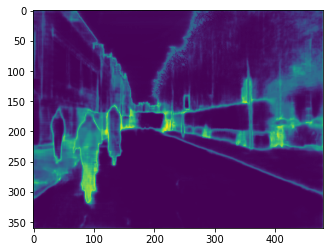

ALEATORIC AUROC:  0.9290679566846861
ALEATORIC AUPR:  0.9930863612483379
ALEATORIC VISUALIZATION


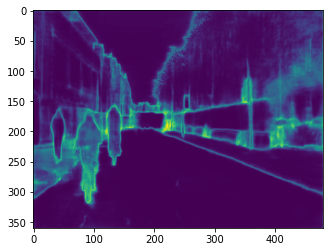

EPISTEMIC AUROC:  0.8974333638756518
EPISTEMIC AUPR:  0.989873513382829
EPISTEMIC VISUALIZATION


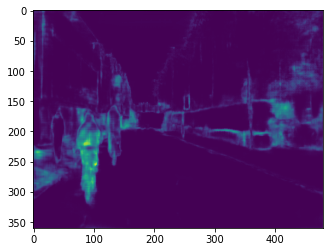

ORIGINAL IMAGES


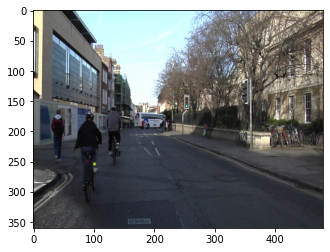

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
IMAGE NUMBER:  1
('/content/drive/MyDrive/SegNet-Tutorial/CamVid/val/0016E5_07999.png',)
ACCURACY:  0.9349479166666667
ENTROPY AUROC:  0.9207448336555272
ENTROPY AUPR:  0.9930669221973746
ENTROPY VISUALIZATION


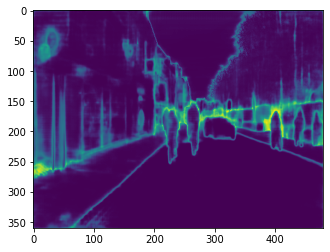

ALEATORIC AUROC:  0.9236308832132187
ALEATORIC AUPR:  0.993296231570865
ALEATORIC VISUALIZATION


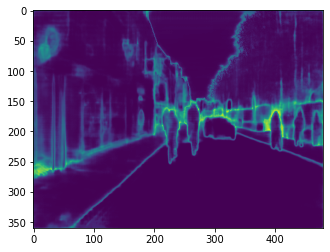

EPISTEMIC AUROC:  0.8807519620454447
EPISTEMIC AUPR:  0.989948817880824
EPISTEMIC VISUALIZATION


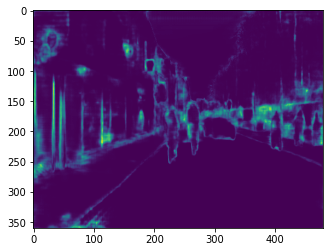

ORIGINAL IMAGES


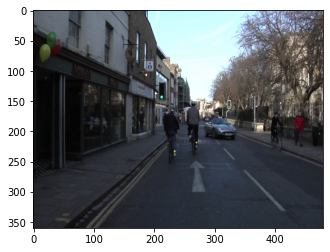

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
# before running this cell, make sure line 98 (out = self.softmax(out)) in tiramisu.py is commented out

# NUM_IMGS = len(val_loader.dataset.imgs)
NUM_IMGS = 2

originals, res, targs, paths = get_results(model, val_loader, num_samples=4)

probs = get_preds(res, NUM_IMGS)

overall_acc = []
overall_ent_auroc = []
overall_ent_aupr = []
overall_au_auroc = []
overall_au_aupr = []
overall_eu_auroc = []
overall_eu_aupr = []

from sklearn.metrics import roc_auc_score, average_precision_score
for i in range(NUM_IMGS):
    entropy = calc_entropies(probs)[i]
    aleatoric = calc_aleatoric(probs)[i]
    epistemic = entropy - aleatoric
    
    # original image shape = (12, 360, 480)
    res_reshaped = np.mean(res[i], axis=0)
    res_reshaped = np.reshape(res_reshaped, (res_reshaped.shape[0], res_reshaped.shape[1] * res_reshaped.shape[2]))
    res_reshaped = np.argmax(res_reshaped, axis=0)
    correct_pixels = np.equal(res_reshaped, targs[i])

    print("IMAGE NUMBER: ", i)
    print(paths[i])
    
    # accuracy
    acc = np.count_nonzero(correct_pixels)/(360*480)
    overall_acc.append(acc)
    print("ACCURACY: ", acc)
    
    # entropy
    ent_auroc = roc_auc_score(correct_pixels, np.negative(entropy))
    ent_aupr = average_precision_score(correct_pixels, np.negative(entropy))
    overall_ent_auroc.append(ent_auroc)
    overall_ent_aupr.append(ent_aupr)
    print("ENTROPY AUROC: ", ent_auroc)
    print("ENTROPY AUPR: ", ent_aupr)
    print("ENTROPY VISUALIZATION")
    entropy = np.asarray(entropy)
    entropy = np.reshape(entropy, (360, 480))
    plt.imshow(entropy)
    # plt.axis("off")
    # plt.savefig("/content/drive/MyDrive/pytorch_tiramisu/ENT/entropy" +  paths[i][0][-16:-4] + ".png", 
    #             facecolor='k', 
    #             bbox_inches='tight')
    plt.show()
    
    # aleatoric uncertainty
    au_auroc = roc_auc_score(correct_pixels, np.negative(aleatoric))
    au_aupr = average_precision_score(correct_pixels, np.negative(aleatoric))
    overall_au_auroc.append(au_auroc)
    overall_au_aupr.append(au_aupr)
    print("ALEATORIC AUROC: ", au_auroc)
    print("ALEATORIC AUPR: ", au_aupr)
    print("ALEATORIC VISUALIZATION")
    aleatoric = np.asarray(aleatoric)
    aleatoric = np.reshape(aleatoric, (360, 480))
    plt.imshow(aleatoric)
    # plt.axis("off")
    # plt.savefig("/content/drive/MyDrive/pytorch_tiramisu/AU/aleatoric" +  paths[i][0][-16:-4] + ".png", 
    #             facecolor='k', 
    #             bbox_inches='tight')
    plt.show()
    
    # epistemic uncertainty
    eu_auroc = roc_auc_score(correct_pixels, np.negative(epistemic))
    eu_aupr = average_precision_score(correct_pixels, np.negative(epistemic))
    overall_eu_auroc.append(eu_auroc)
    overall_eu_aupr.append(eu_aupr)
    print("EPISTEMIC AUROC: ", eu_auroc)
    print("EPISTEMIC AUPR: ", eu_aupr)
    print("EPISTEMIC VISUALIZATION")
    epistemic = np.asarray(epistemic)
    epistemic = np.reshape(epistemic, (360, 480))
    plt.imshow(epistemic)
    # plt.axis("off")
    # plt.savefig("/content/drive/MyDrive/pytorch_tiramisu/EU/epistemic" +  paths[i][0][-16:-4] + ".png", 
    #             facecolor='k', 
    #             bbox_inches='tight')
    plt.show()

    # original images
    print("ORIGINAL IMAGES")
    tensor = originals[i]
    img = img_utils.decode_image(tensor)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    # plt.axis('off')
    # plt.savefig("/content/drive/MyDrive/pytorch_tiramisu/IMG/img" +  paths[i][0][-16:-4] + ".png", 
    #             facecolor='k', 
    #             bbox_inches='tight')
    plt.show()
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

# print model's prediction to screen and save model's prediction to a directory
def get_preds_only(model, loader):
    model.eval()
    with torch.no_grad():
        for inputs, _, path in loader:
            mc = []
            data = inputs.to(torch.device("cuda"))
            output = model(data)
            pred = train_utils.get_predictions(output)
            print(path[0][-9:-4])
            img_utils.save_annotated(
                pred[0], 
                '/content/drive/MyDrive/pytorch_tiramisu/PRED/prediction',
                path[0][-16:-4] # part of the path w/ the img number, this is kinda janky b/c im not comfortable enough with regex
            )
    

# get_preds_only(model, val_loader)

In [ ]:
print("overall_acc =", np.mean(overall_acc))
print("overall_ent_auroc =", np.mean(overall_ent_auroc))
print("overall_ent_aupr =", np.mean(overall_ent_aupr))
print("overall_au_auroc =", np.mean(overall_au_auroc))
print("overall_au_aupr =", np.mean(overall_au_aupr))
print("overall_eu_auroc =", np.mean(overall_eu_auroc))
print("overall_eu_aupr =", np.mean(overall_eu_aupr))

overall_acc = 0.9259259259259259
overall_ent_auroc = 0.9239621261774682
overall_ent_aupr = 0.9929853552050347
overall_au_auroc = 0.9263494199489524
overall_au_aupr = 0.9931912964096015
overall_eu_auroc = 0.8890926629605482
overall_eu_aupr = 0.9899111656318265
